In [1]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
# Render the figure in a notebook:
%matplotlib inline  

from scipy import stats

from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import plot_tree

from sklearn import metrics

import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F

from torchmetrics.classification import Accuracy
from torchmetrics.classification import Recall
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from torchmetrics import R2Score
from torchmetrics import MeanAbsoluteError

from sklearn.preprocessing import StandardScaler

In [9]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
x_train = pd.read_csv('../no_nontoxic_nans_X_train.csv',index_col=0)
y_train = pd.read_csv('../no_nontoxic_nans_y_train.csv',index_col=0)

x_val = pd.read_csv('../no_nontoxic_nans_x_val.csv',index_col=0)
y_val = pd.read_csv('../no_nontoxic_nans_y_val.csv',index_col=0)

x_test = pd.read_csv('../no_nontoxic_nans_x_test.csv',index_col=0)
y_test = pd.read_csv('../no_nontoxic_nans_y_test.csv',index_col=0)

In [3]:
#Remove all nan values from the df
mask = x_train.notna().all(axis=1)

x_train_clean = x_train[mask]
y_train_clean = y_train[mask]

mask2 = x_test.notna().all(axis=1)

x_test_clean = x_test[mask2]
y_test_clean = y_test[mask2]

mask3 = x_val.notna().all(axis=1)

x_val_clean = x_val[mask3]
y_val_clean = y_val[mask3]

In [4]:
### You have been using DataFrames because these are easy to deal with but here we need the data as an array

x_train_array = x_train_clean.to_numpy()
x_train_tensor = torch.Tensor(x_train_array)

### Now some properties will be printed so you can see how this is similar to a NumPy array

print(f'X_train_tensor = {x_train_tensor}')

print(f'Size of X_train_tensor = {x_train_tensor.size()}') 

print(f'Data type of X_train_tensor = {x_train_tensor.dtype}')

X_train_tensor = tensor([[ 0.7823,  0.7823, -0.4119,  ..., -0.0907, -0.2697, -0.1562],
        [ 0.5145,  0.5145, -0.7155,  ..., -0.0907, -0.2697, -0.1562],
        [-1.5689, -1.5689,  0.6186,  ..., -0.0907, -0.2697, -0.1562],
        ...,
        [ 0.2563,  0.2563, -0.5645,  ..., -0.0907, -0.2697, -0.1562],
        [ 0.2330,  0.2330, -0.1187,  ..., -0.0907, -0.2697, -0.1562],
        [ 0.7342,  0.7342, -0.7105,  ..., -0.0907, -0.2697, -0.1562]])
Size of X_train_tensor = torch.Size([3607, 217])
Data type of X_train_tensor = torch.float32


In [5]:
x_val_array = x_val_clean.to_numpy()
x_val_tensor = torch.Tensor(x_val_array)

y_train_array = y_train_clean['toxic'].to_numpy()
y_train_tensor = torch.Tensor(y_train_array)

y_val_array = y_val_clean['toxic'].to_numpy()
y_val_tensor = torch.Tensor(y_val_array)

x_test_array = x_test_clean.to_numpy()
x_test_tensor = torch.Tensor(x_test_array)

y_test_array = y_test_clean.to_numpy()
y_test_tensor = torch.Tensor(y_test_array)

In [6]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

In [7]:
class DNN_3_layer(nn.Module):
    def __init__(self):
        super(DNN_3_layer, self).__init__()
        self.fc1 = nn.Linear(217, 108)        
        self.fc2 = nn.Linear(108, 54)
        self.fc3 = nn.Linear(54, 27)
        self.fc4 = nn.Linear(27,2)
           
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x) # For the final layer we use raw logits for the cross entropy loss
        return x

In [26]:
#test the SGD model with optimised params
def test_SGD_metrics(network, learning_rate, best_epochs, trainloader, x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor, x_test_tensor, y_test_tensor):
    epoch_list = []
    avg_train_loss_list =[]
    
    network.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)

    num_epochs = best_epochs  
    torch.manual_seed(0)

    for epoch in range(1,num_epochs+1):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data 
            optimizer.zero_grad() 
            outputs = network(inputs)
            loss = criterion(outputs, labels.long()) 
            loss.backward() 
            optimizer.step() 
            running_loss += loss.item() 
                
        avg_train_loss = running_loss / len(trainloader) 
        avg_train_loss_list.append(avg_train_loss)
        epoch_list.append(epoch)

    network.eval()
    with torch.no_grad():  # stops gradient tracking
        y_train_logits = network(x_train_tensor).detach() 
        y_train_pred = torch.argmax(y_train_logits, dim=1) 

        y_val_logits = network(x_val_tensor).detach() 
        y_val_pred = torch.argmax(y_val_logits, dim=1) 

        y_test_logits = network(x_test_tensor).detach() 
        y_test_pred = torch.argmax(y_test_logits, dim=1) 

    ConfusionMatrixDisplay.from_predictions(y_train_tensor, y_train_pred)
    ConfusionMatrixDisplay.from_predictions(y_val_tensor, y_val_pred)
    ConfusionMatrixDisplay.from_predictions(y_test_tensor, y_test_pred)

    train_bal_acc = metrics.balanced_accuracy_score(y_train_tensor, y_train_pred)
    print('SKlearn Balanced Accuracy train:',float(train_bal_acc))

    val_bal_acc = metrics.balanced_accuracy_score(y_val_tensor, y_val_pred)
    print('SKlearn Balanced Accuracy val:',float(val_bal_acc))

    test_bal_acc = metrics.balanced_accuracy_score(y_test_tensor, y_test_pred)
    print('SKlearn Balanced Accuracy test:',float(test_bal_acc))
    
    train_recall = metrics.recall_score(y_train_tensor, y_train_pred)
    print('SKlearn Recall train:',float(train_recall))

    val_recall = metrics.recall_score(y_val_tensor, y_val_pred)
    print('SKlearn Recall val:',float(val_recall))

    test_recall = metrics.recall_score(y_test_tensor, y_test_pred)
    print('SKlearn Recall test:',float(test_recall))

    train_precision = metrics.precision_score(y_train_tensor, y_train_pred)
    print('SKlearn Precision train:',float(train_precision))

    val_precision = metrics.precision_score(y_val_tensor, y_val_pred)
    print('SKlearn Precision val:',float(val_precision))

    test_precision = metrics.precision_score(y_test_tensor, y_test_pred)
    print('SKlearn Precision test:',float(test_precision))

    train_f1 = metrics.f1_score(y_train_tensor, y_train_pred)
    print('SKlearn F1 train:',float(train_f1))

    val_f1 = metrics.f1_score(y_val_tensor, y_val_pred)
    print('SKlearn F1 val:',float(val_f1))
    
    test_f1 = metrics.f1_score(y_test_tensor, y_test_pred)
    print('SKlearn F1 val:',float(test_f1))


SKlearn Balanced Accuracy train: 0.9736656282837617
SKlearn Balanced Accuracy val: 0.7707488145416228
SKlearn Balanced Accuracy test: 0.7705013192612138
SKlearn Recall train: 0.9485627836611196
SKlearn Recall val: 0.7716346153846154
SKlearn Recall test: 0.76
SKlearn Precision train: 0.9989378651088688
SKlearn Precision val: 0.7925925925925926
SKlearn Precision test: 0.7855297157622739
SKlearn F1 train: 0.9730988101396792
SKlearn F1 val: 0.781973203410475
SKlearn F1 val: 0.772554002541296


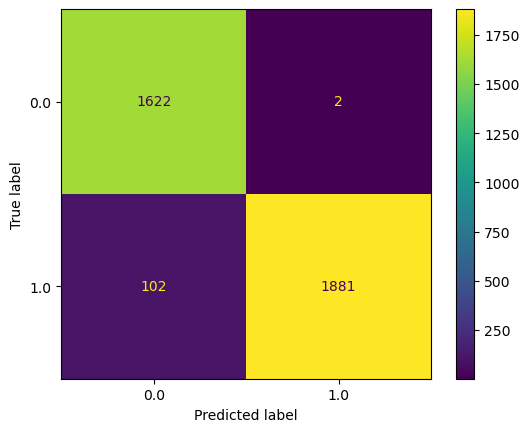

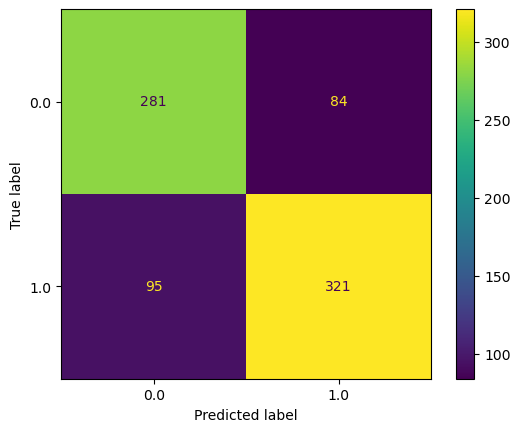

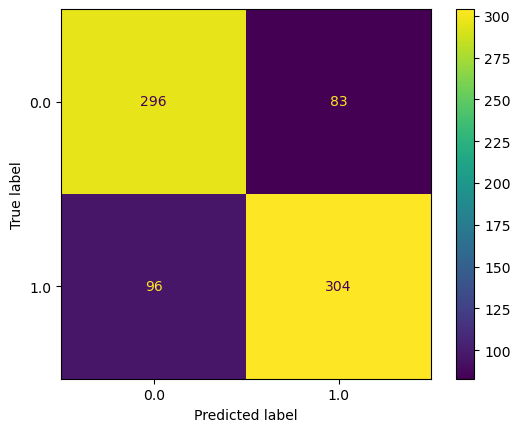

In [27]:
network = DNN_3_layer()
test_SGD_metrics(network, 0.14, 100, trainloader, x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor, x_test_tensor, y_test_tensor)

# Redo the model with Sigmoid Activation Function

In [28]:
class DNN_3_layer_sigmoid(nn.Module):
    def __init__(self):
        super(DNN_3_layer_sigmoid, self).__init__()
        self.fc1 = nn.Linear(217, 108)        
        self.fc2 = nn.Linear(108, 54)
        self.fc3 = nn.Linear(54, 27)
        self.fc4 = nn.Linear(27,2)
           
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = self.fc4(x) # For the final layer we use raw logits for the cross entropy loss
        return x

In [ ]:
def optimise_learning_rate(net_param, trainloader, x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor):
    avg_train_loss_list =[]
    param_bacc_train_list = []
    param_bacc_val_list = []

    torch.manual_seed(0)
    learning_rate = np.linspace(0.001,0.8,30, dtype=float)

    for i in learning_rate:
        net_param.train()
        criterion_param = nn.CrossEntropyLoss()
        optimizer_param = torch.optim.SGD(net_param.parameters(), lr=i)

        num_epochs = 50  

        for epoch in range(1,num_epochs+1):
            running_loss = 0.0
            for i, data in enumerate(trainloader):
                inputs, labels = data 
                optimizer_param.zero_grad() 
                outputs = net_param(inputs) 
                loss = criterion_param(outputs, labels.long()) 
                loss.backward() 
                optimizer_param.step() 
                running_loss += loss.item() 
                
            avg_train_loss = running_loss / len(trainloader) 
            avg_train_loss_list.append(avg_train_loss)
            #print('Epoch',epoch,'Loss =',avg_train_loss) 

        net_param.eval()  # sets layers to evaluation mode
        with torch.no_grad():  # stops gradient tracking
            y_train_logits = net_param(x_train_tensor).detach() 
            y_train_pred = torch.argmax(y_train_logits, dim=1) 
        macro_recall = Recall(task='multiclass', num_classes=2, average='macro')

        NN_param_train_bacc = macro_recall(y_train_pred, y_train_tensor)
        #print('Balanced Accuracy train:',float(NN_param_train_bacc))
        param_bacc_train_list.append(NN_param_train_bacc)

        with torch.no_grad(): 
            y_val_logits = net_param(x_val_tensor).detach() 
            y_val_pred = torch.argmax(y_val_logits, dim=1) # If the first index is larger it will return 0 and if the second is 1 
        NN_param_val_bacc = macro_recall(y_val_pred, y_val_tensor)
        #print('Balanced Accuracy val:',float(NN_param_val_bacc))
        param_bacc_val_list.append(NN_param_val_bacc)

    # plt.plot(learning_rate, avg_train_loss_list, '-o')
    # plt.xlabel('Learning Rate')
    # plt.ylabel('Average Loss Training')
    # plt.show();

    plt.plot(learning_rate, param_bacc_train_list, '-o', label = 'Train')
    plt.plot(learning_rate, param_bacc_val_list, '-o', label = 'Validation', color='skyblue')
    plt.xlabel('Learning Rate')
    plt.ylabel('Balanced Accuracy')
    plt.legend()
    plt.show();
